In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chart = pd.read_csv("../data/chart_events_6_23.csv")
comorbid = pd.read_csv("../data/comorbidities_6_23.csv")
gcs = pd.read_csv("../data/gcs_over_time_6_23.csv")
rx = pd.read_csv("../data/rx_6_23.csv")
proc = pd.read_csv("../data/procedures_6_16.csv")

C:\Users\qrJos\AppData\Local\Temp\ipykernel_23232\4192065990.py:1: DtypeWarning: Columns (6,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  chart = pd.read_csv("../data/chart_events_6_23.csv")
C:\Users\qrJos\AppData\Local\Temp\ipykernel_23232\4192065990.py:3: DtypeWarning: Columns (9,11,15,39,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  gcs = pd.read_csv("../data/gcs_over_time_6_23.csv")


In [3]:
# --- Quinn's code for getting single patient data with survival time ---
# Convert datetime columns
chart['dischtime'] = pd.to_datetime(chart['dischtime'], format='mixed')
chart['admittime'] = pd.to_datetime(chart['admittime'], format='mixed')
chart['dob'] = pd.to_datetime(chart['dob'], format='mixed')
chart['dod'] = pd.to_datetime(chart['dod'], format='mixed')
chart['dod_hosp'] = pd.to_datetime(chart['dod_hosp'], format='mixed')

# Calculate age at admission (more robust method)
chart['age.at.admit'] = (chart['admittime'].dt.year - chart['dob'].dt.year) + \
                       ((chart['admittime'].dt.month - chart['dob'].dt.month) + \
                       (chart['admittime'].dt.day - chart['dob'].dt.day)/30)/12

# Calculate length of stay (alternative method)
chart['los'] = (chart['dischtime'] - chart['admittime']).dt.days


# Get one entry per subject (most recent admission)
single_per_subject = (chart.sort_values(['subject_id', 'admittime'], ascending=[True, False])
                     .groupby('subject_id')
                     .first()
                     .reset_index())

# Add died_in_hosp flag and filter to discharged patients
single_per_subject['died_in_hosp'] = single_per_subject['dod_hosp'].notna()
single_per_subject = single_per_subject[~single_per_subject['died_in_hosp']]

# Calculate survival time (capped at 90 days)
single_per_subject['survival_days'] = (single_per_subject['dod'] - single_per_subject['dischtime']).dt.days
single_per_subject['survival_days'] = single_per_subject['survival_days'].fillna(90)
single_per_subject['survival_days'] = single_per_subject['survival_days'].clip(upper=90)

In [4]:
# --- Hanrui's code for diagnoses processing ---
diag_dict = pd.read_csv("../data/diag_dict.csv", dtype={'diagnosis_raw': str, 'diagnose_big_class': str})

# Process diagnoses
diag_group = (single_per_subject[['subject_id', 'diagnosis']]
              .assign(diagnosis=lambda x: x['diagnosis'].str.split(r'\s*[;,]\\s*'))
              .explode('diagnosis')
              .assign(diagnosis=lambda x: x['diagnosis'].str.upper().str.strip())
              .merge(diag_dict, left_on='diagnosis', right_on='diagnosis_raw', how='left'))

# Check for unmatched diagnoses
unmatched = (diag_group[diag_group['diagnose_big_class'].isna() & 
             diag_group['diagnosis'].notna() & 
             (diag_group['diagnosis'] != "")]
             .drop_duplicates('diagnosis'))

# Get unique diagnoses per subject
diag_group = (diag_group[['subject_id', 'diagnose_big_class']]
              .drop_duplicates())

# Merge back to main dataframe
sps = single_per_subject.merge(diag_group, on='subject_id', how='left')

In [5]:
sps = single_per_subject.merge(diag_group, on='subject_id', how='left')

In [6]:
# KATHERINE BRUMBERG'S CODE FOR PIVOTING IN CHART (CONVERTED TO PYTHON)

chart_wide = (
    chart.pivot_table(index=['subject_id', 'hadm_id', 'gender', 'expire_flag', 
                      'marital_status', 'intervention.group'],
                     columns='label',
                     values='valuenum',
                     aggfunc='mean')  # takes first value if duplicates exist
    .reset_index()
    .rename_axis(None, axis=1)
)

In [7]:
sps = pd.merge(
    sps,
    chart_wide,
    on='subject_id',
    how='left'  # This ensures only matching subject_ids are kept
)

In [8]:
sps = single_per_subject.merge(diag_group, on='subject_id', how='left')

In [10]:
sps.drop(columns = ['expire_flag_1', 'gender_1', 'Unnamed: 0'], inplace=True, errors='ignore')

sps['ethnicity'] = sps['ethnicity'].replace(['HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC OR LATINO'], 'HISPANIC/LATINO')
sps['ethnicity'] = sps['ethnicity'].replace(['UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER'], 'UNKNOWN/NOT SPECIFIED')
sps['ethnicity'] = sps['ethnicity'].replace(['ASIAN - CAMBODIAN', 'ASIAN - OTHER', 'ASIAN - JAPANESE', 'ASIAN - VIETNAMESE', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN'], 'ASIAN')
sps['ethnicity'] = sps['ethnicity'].replace(['BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'], 'BLACK/AFRICAN AMERICAN')
sps['ethnicity'] = sps['ethnicity'].replace(['WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN', 'WHITE - BRAZILIAN'], 'WHITE')

In [12]:
drug_categories = {
  "Anesthetics / Sedatives": ["Midazolam", "Midazolam HCl", "Propofol", "Propofol (Generic)", "Etomidate", "Ketamine", "Lidocaine 1%", "Lidocaine 0.5%", "Lidocaine 1%/Epinephrine 1:100000", "Lidocaine 5% Patch", "Lidocaine Jelly 2% (Urojet)", "Lidocaine-Prilocaine", "Succinylcholine", "Vecuronium Bromide", "Rocuronium", "Cisatracurium Besylate", "Pancuronium Bromide"],
  
  "Opioid Analgesics": ["Fentanyl Citrate", "Fentanyl", "Fentanyl Patch", "Hydromorphone", "HYDROmorphone (Dilaudid)", "Meperidine", "Morphine Sulfate", "Morphine Infusion ? Comfort Care Guidelines", "Morphine Sulfate (Oral Soln.)", "Oxycodone", "OxycoDONE (Immediate Release)", "Oxycodone SR (OxyconTIN)", "Oxycodone (Sustained Release)", "Oxycodone-Acetaminophen", "OxycoDONE-Acetaminophen Elixir", "Hydrocodone-Acetaminophen", "Codeine Phosphate", "Codeine Sulfate", "Methadone", "Methadone HCl", "Tramadol (Ultram)"],
  
  "Non-Opioid Analgesics": ["Acetaminophen", "Acetaminophen IV", "Acetaminophen (Liquid)", "Acetaminophen (Rectal)", "Acetaminophen w/Codeine", "Acetaminophen-Caff-Butalbital", "Ibuprofen", "Ibuprofen Suspension", "Naproxen", "Indomethacin", "Ketorolac", "Celecoxib", "Aspirin", "Aspirin EC", "Aspirin (Buffered)"],
  
  "Antibiotics": ["Amoxicillin", "Amoxicillin Oral Susp.", "Ampicillin Sodium", "Piperacillin-Tazobactam", "Piperacillin-Tazobactam Na", "Nafcillin", "Oxacillin", "Cefazolin", "CefazoLIN", "CefTRIAXone", "CeftriaXONE", "Ceftriaxone", "Cefepime", "CefePIME", "Ceftazidime", "CefTAZidime", "CeftazIDIME", "Cephalexin", "Ciprofloxacin", "Ciprofloxacin IV", "Ciprofloxacin HCl", "Levofloxacin", "Azithromycin", "Erythromycin 0.5% Ophth Oint", "Vancomycin", "Vancomycin HCl", "Vancomycin Oral Liquid", "Gentamicin", "Gentamicin Sulfate", "Gentamicin 0.3% Ophth. Soln", "Tobramycin Sulfate", "Amikacin", "Meropenem", "Aztreonam", "Metronidazole", "MetRONIDAZOLE (FLagyl)", "Rifampin", "Doxycycline Hyclate", "Clindamycin", "Sulfameth/Trimethoprim DS", "Sulfameth/Trimethoprim Suspension", "Nitrofurantoin (Macrodantin)", "Dapsone", "Amphotericin B"],
  
  "Anticoagulants": ["Heparin", "Heparin Sodium", "Heparin Flush CVL (100 units/ml)", "Heparin Flush (100 units/ml)", "Heparin Flush PICC (100 units/ml)", "Heparin Flush Port (10units/ml)", "Heparin Flush CRRT (5000 Units/mL)", "Heparin Flush (10 units/ml)", "Enoxaparin Sodium", "Warfarin"],
  
  "Antiplatelets": ["Clopidogrel", "Clopidogrel Bisulfate", "Dipyridamole", "Dipyridamole-Aspirin"],
  
  "Antidepressants": ["Citalopram", "Citalopram Hydrobromide", "Escitalopram Oxalate", "Fluoxetine", "Fluoxetine HCl", "Paroxetine", "Paroxetine HCl", "Sertraline", "Sertraline HCl", "Venlafaxine XR", "Duloxetine", "Amitriptyline", "Amitriptyline HCl", "Nortriptyline", "Doxepin HCl", "Trazodone", "Trazodone HCl", "Mirtazapine", "Bupropion", "BuPROPion (Sustained Release)", "Bupropion SR"],
  
  "Antipsychotics": ["Haloperidol", "Risperidone", "Olanzapine", "OLANZapine", "Olanzapine (Disintegrating Tablet)", "Quetiapine Fumarate"],
  
  "Antidiabetics": ["Insulin", "Insulin Human Regular", "Humulin-R Insulin", "Glipizide XL", "Glyburide", "GlyBURIDE", "Metformin (Glucophage)", "Rosiglitazone Maleate"],
  
  "Antiepileptics": ["Phenytoin", "Phenytoin Sodium", "Phenytoin Sodium (IV)", "Phenytoin Sodium Extended", "Phenytoin (Suspension)", "Fosphenytoin", "Fosphenytoin Sodium", "Levetiracetam", "LeVETiracetam", "LeVETiracetam Oral Solution", "Lacosamide", "Valproic Acid", "Divalproex Sodium", "Carbamazepine", "Oxcarbazepine", "Lamotrigine", "LaMOTrigine", "Topiramate", "Topiramate (Topamax)", "Gabapentin", "Primidone", "Phenobarbital", "Phenobarbital Sodium"],
  
  "Beta Blockers": ["Metoprolol", "Metoprolol Tartrate", "Metoprolol XL", "Metoprolol Succinate XL", "Atenolol", "Propranolol HCl", "Carvedilol", "Labetalol", "Labetalol HCl", "Nadolol", "Sotalol", "Sotalol HCl"],
  
  "ACE ARBs": ["Lisinopril", "Enalapril Maleate", "Ramipril", "Quinapril", "Moexipril", "Captopril", "Losartan Potassium", "Valsartan", "Irbesartan"],
  
  "Calcium Channel Blockers": ["Amlodipine", "Amlodipine Besylate", "Nifedipine", "NIFEdipine CR", "Nifedipine CR", "Diltiazem", "Diltiazem Extended-Release", "Verapamil", "Verapamil SR", "Verapamil HCl", "Nicardipine IV", "NiCARdipine IV", "*NF* Nicardipine HCl IV"],
  
  "Diuretics": ["Furosemide", "Hydrochlorothiazide", "Spironolactone", "Bumetanide", "Torsemide", "Triamterene-Hydrochlorothiazide", "Mannitol", "Mannitol 20%", "Mannitol 20 %"],
  
  "Vasodilators": ["Hydralazine", "HydrALAzine", "HydrALAZINE HCl", "Nitroprusside Sodium", "Nitroglycerin", "Nitroglycerin SL", "Isosorbide Mononitrate", "Isosorbide Mononitrate (Extended Release)", "Isosorbide Dinitrate", "Minoxidil", "Prazosin HCl", "Doxazosin", "Terazosin", "Terazosin HCl", "Midodrine", "Midodrine HCl", "Eplerenone"],
  
  "Antiemetics": ["Ondansetron", "Ondansetron HCl", "Dolasetron Mesylate", "Dolasetron Mesylate I.V.", "Prochlorperazine", "Promethazine HCl", "Metoclopramide", "Scopolamine Patch", "Meclizine", "Meclizine HCl"],
  
  "PPIs H2Blockers": ["Omeprazole", "Pantoprazole", "Pantoprazole Sodium", "Lansoprazole", "Lansoprazole Oral Suspension", "Lansoprazole Oral Solution", "Famotidine", "Famotidine (IV)", "Famotidine (PO)", "Ranitidine"],
  
  "Laxatives": ["Senna", "Docusate", "Docusate Sodium", "Docusate Sodium (Liquid)", "Bisacodyl", "Lactulose", "Lactulose Enema", "Polyethylene Glycol", "Magnesium Citrate", "Milk of Magnesia"],
  
  "Respiratory": ["Albuterol", "Albuterol MDI", "Albuterol Inhaler", "Albuterol Neb Soln", "Albuterol 0.083% Neb Soln", "Xopenex", "Ipratropium Bromide MDI", "Ipratropium Bromide Neb", "Albuterol-Ipratropium", "Fluticasone Propionate 110mcg", "Fluticasone-Salmeterol (250/50)", "Fluticasone-Salmeterol Diskus (100/50)", "Fluticasone-Salmeterol Diskus (250/50)", "Fluticasone-Salmeterol Diskus (500/50)", "Acetylcysteine (IV)", "Acetylcysteine 20%", "Guaifenesin"],
  
  "Steroids": ["Dexamethasone", "Dexamethasone Sod Phosphate", "Hydrocortisone Na Succ.", "Hydrocortisone (Rectal) 2.5% Cream", "Methylprednisolone Na Succ", "MethylPREDNISolone Sodium Succ", "Prednisone", "PredniSONE", "PrednisoLONE Acetate 1% Ophth. Susp.", "Fludrocortisone Acetate"],
  
  "Electrolytes IV Fluids": ["0.9% Sodium Chloride", "0.45% Sodium Chloride", "5% Dextrose", "D5W", "D5W (EXCEL BAG)", "5% Dextrose (EXCEL BAG)", "D10W", "D25W", "D5 1/2NS", "D5NS", "D5LR", "LR", "Lactated Ringers", "PlasmaLyte", "Potassium Chloride", "KCl", "Potassium Chl 20 mEq / 1000 mL NS", "Potassium Chl 40 mEq / 1000 mL NS", "Potassium Chl 20 mEq / 1000 mL D5W", "Potassium Chl 40 mEq / 1000 mL D5W", "Potassium Chl 20 mEq / 1000 mL D5 1/2 NS", "Potassium Chl 40 mEq / 1000 mL D5 1/2 NS", "Potassium Chl 20 mEq / 1000 mL D5NS", "Potassium Chloride (Powder)", "Potassium Chloride Replacement (Oncology)", "Potassium Phosphate", "Sodium Chloride", "Sodium Chloride 3% (Hypertonic)", "Sodium Chloride (23.4%) Kit", "23.4% Sodium Chloride", "Sodium Bicarbonate", "sodium bicarb", "Sodium CITRATE 4%", "Calcium Gluconate", "Calcium Chloride", "Calcium Replacement (Oncology)", "Magnesium Sulfate", "Magnesium Oxide", "Sodium Phosphate"],
  
  "Ophthalmic": ["Durezol 0.05% drops", "Dorzolamide 2%/Timolol 0.5% Ophth.", "Gentamicin 0.3% Ophth. Soln", "Latanoprost 0.005% Ophth. Soln.", "Timolol Maleate 0.5%", "Timolol Maleate 0.25%", "Brimonidine Tartrate 0.15% Ophth.", "Artificial Tears", "Artificial Tears Preserv. Free", "Artificial Tear Ointment", "Lacri-Lube Oint", "Tobramycin-Dexamethasone Ophth Susp", "Nevanac", "Vigamox", "nepafenac"],
  
  "Topical Dermatologic": ["Hydrocortisone (Rectal) 2.5% Cream", "Sarna Lotion", "Tretinoin", "Tretinoin (Chemotherapy)", "Miconazole Powder 2%", "Lidocaine 5% Patch", "Clonidine Patch 0.3 mg/24 hr", "Nicotine Patch", "Fentanyl Patch"],
  
  "Chemotherapy Immunosuppressants": ["Mercaptopurine", "Hydroxyurea", "Tacrolimus", "Mycophenolate Mofetil", "Filgrastim", "Deferoxamine (DFO) *IND*", "Tretinoin (Chemotherapy)"],
  
  "Anxiolytics Hypnotics": ["Lorazepam", "Diazepam", "Alprazolam", "ALPRAZolam", "Clonazepam", "Zolpidem Tartrate", "BusPIRone", "Hydroxyzine", "HydrOXYzine"],
  
  "Parkinsons Dementia": ["Carbidopa-Levodopa (25-100)", "Mirapex", "Donepezil", "Memantine", "Namenda"],
  
  "Vitamins Supplements": ["Folic Acid", "FoLIC Acid", "Thiamine", "Thiamine HCl", "Pyridoxine HCl", "Vitamin B Complex", "Cyanocobalamin", "Vitamin D", "Calcitriol", "Vitamin E", "Tocopheryl", "Ascorbic Acid", "Ferrous Sulfate", "Ferrous Gluconate", "Polysaccharide Iron Complex", "Zinc Sulfate", "Fish Oil (Omega 3)", "Coenzyme Q10 Study Drug"],
  
  "Miscellaneous": ["Naloxone HCl", "Flumazenil", "Methylene Blue", "Glucagon", "Cosyntropin", "Epoetin Alfa", "Albumin 5%", "Albumin 25% (12.5g / 50mL)", "Bicitra", "Cholestyramine", "Mesalamine", "Sucralfate", "Simethicone", "Bismuth Subsalicylate", "Readi-Cat 2 (Barium Sulfate 2% Suspension)", "Sodium Polystyrene Sulfonate", "Neutra-Phos", "Medium Chain Triglycerides", "Sodium Chloride Nasal", "Sodium Chloride 0.9% Flush", "Syringe", "Syringe (IV Room)", "Syringe (Intrathecal)", "Bag", "Vial", "Soln.", "Soln"]
}



In [14]:
# --- Medication processing ---
# Create drug category mapping (assuming drug_categories is a dict)
drug_to_category = {drug: cat for cat, drugs in drug_categories.items() for drug in drugs}

# Map drugs to categories
rx['drug_cat'] = rx['drug'].map(drug_to_category).fillna("Uncategorized")

# Collapse drugs by subject
rx_collapsed = (rx.groupby('subject_id')
                .agg({'drug_cat': lambda x: ', '.join(sorted(set(x)))},
                     {'formulary_drug_cd': lambda x: ', '.join(sorted(set(x)))})
                .reset_index())

# Merge back to main dataframe
single_per_subject = single_per_subject.merge(rx_collapsed, on='subject_id', how='left')

# --- GCS scores processing ---
# Get most recent GCS entries
result = (gcs.sort_values(['subject_id', 'label', 'charttime'], ascending=[True, True, False])
          .groupby(['subject_id', 'label'])
          .first()
          .reset_index())

# Pivot to wide format
gcs_wide = (result.pivot(index='subject_id', columns='label', values='value')
            .add_prefix('GCS_')
            .rename(columns=lambda x: x.replace("GCS - ", "").replace(" ", "_"))
            .rename(columns={"GCS_GCS_Total": "GCS_Total"}))

gcs_wide['GCS_Total'] = pd.to_numeric(gcs_wide['GCS_Total'])

# Merge back to main dataframe
single_per_subject = single_per_subject.merge(gcs_wide, on='subject_id', how='left')

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [16]:
from sklearn.impute import SimpleImputer

# Select features and target
X = single_per_subject.drop(columns=['survival_days', 'subject_id'])  # Exclude ID and target
y = single_per_subject['survival_days']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Combine Preprocessing Steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 5. Create and Train Model Pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Unnamed: 0', 'hadm_id',
                                                   'icustay_id', 'itemid',
                                                   'cgid', 'valuenum',
                                                   'observation.number',
                                                   'hospital_expire_flag',
                                                   'has_chartevents_data',
                                                   'n.admit', 'expire_flag',
                                                   'expire_flag_1',
                                                   'age.at.admit', 'los',
                                                   'GCS_Total']),
                                                 ('cat',
                                                  Pipe...
                                                   'unitname', 'deathtime',
                                                   'admission_type',
                                                   'admission_location',
                                                   'discharge_location',
                                                   'insurance', 'language',
                                                   'religion', 'marital_status',
                                                   'ethnicity', 'edregtime',
                                                   'edouttime', 'diagnosis',
                                                   'window.max', 'first.admit',
                                                   'four.hours.post.admit',
                                                   'proc.in.four.hrs.admit',
                                                   'intervention.group',
                                                   'gender', 'dod_ssn', ...])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [17]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print("\nModel Evaluation:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    
    # Create evaluation dataframe
    eval_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Absolute_Error': np.abs(y_test - y_pred)
    })
    
    return eval_df


Model Evaluation:
MAE: 4.02
MSE: 158.99
R² Score: 0.25


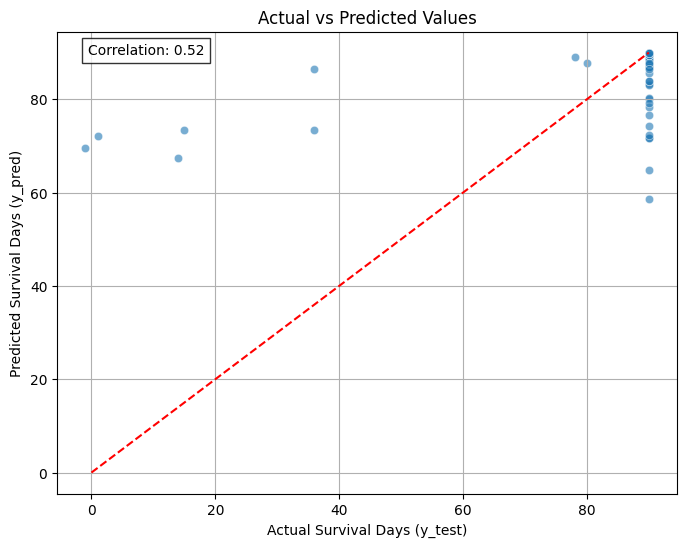

In [18]:
eval_results = evaluate_model(rf_model, X_test, y_test)

y_pred = rf_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Add perfect prediction line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--')

# Add labels and title
plt.xlabel('Actual Survival Days (y_test)')
plt.ylabel('Predicted Survival Days (y_pred)')
plt.title('Actual vs Predicted Values')

# Add correlation text box
corr = np.corrcoef(y_test, y_pred)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True)
plt.show()